In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("../data/Groceries_dataset.csv")
items_array = df["itemDescription"].unique()
print("Number of unique items:", len(items_array))
df.head()

Number of unique items: 167


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
df["itemDescription"].value_counts()

whole milk               2502
other vegetables         1898
rolls/buns               1716
soda                     1514
yogurt                   1334
                         ... 
rubbing alcohol             5
bags                        4
baby cosmetics              3
kitchen utensil             1
preservation products       1
Name: itemDescription, Length: 167, dtype: int64

In [4]:
df.Member_number = 1808
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,1808,05-01-2015,whole milk
2,1808,19-09-2015,pip fruit
3,1808,12-12-2015,other vegetables
4,1808,01-02-2015,whole milk
...,...,...,...
38760,1808,08-10-2014,sliced cheese
38761,1808,23-02-2014,candy
38762,1808,16-04-2014,cake bar
38763,1808,03-12-2014,fruit/vegetable juice


In [27]:
item = "whole milk"

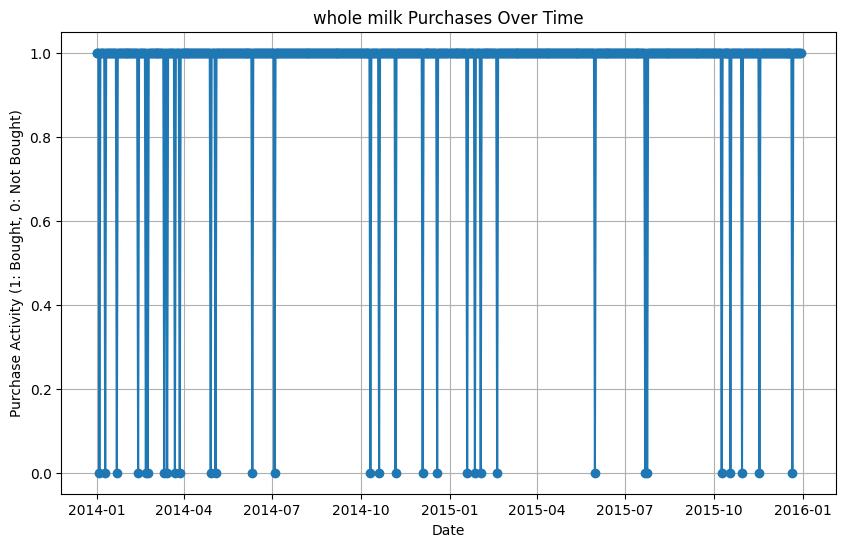

In [28]:
df['{}'.format(item)] = df['itemDescription'].apply(lambda x: 1 if item in x.lower() else 0)

# Group by date and get the maximum value of the ToiletPaper column (1 if toilet paper was purchased, 0 otherwise)
time_series_data = df.groupby('Date')['{}'.format(item)].max().reset_index()

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(time_series_data['Date'], time_series_data['{}'.format(item)], marker='o')
plt.title('{} Purchases Over Time'.format(item))
plt.xlabel('Date')
plt.ylabel('Purchase Activity (1: Bought, 0: Not Bought)')
plt.grid(True)
plt.show()

/var/folders/k0/4b5w69j156334dt2nqbt9mfw0000gn/T/ipykernel_4901/256764875.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_series_data = df.resample('W-Mon', on='Date').sum().reset_index()


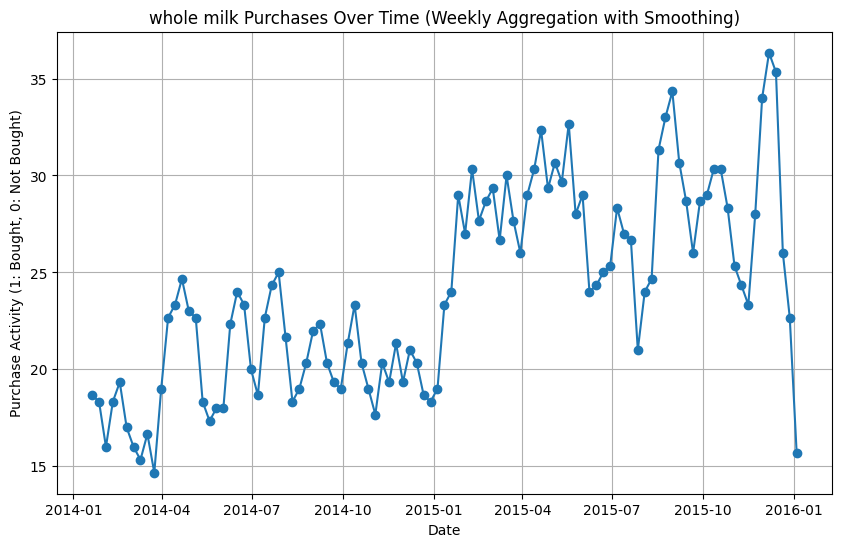

In [29]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Create a new column to indicate whether toilet paper was purchased on each transaction
df['{}'.format(item)] = df['itemDescription'].apply(lambda x: 1 if item in x.lower() else 0)

# Group by week and get the sum of the ToiletPaper column
time_series_data = df.resample('W-Mon', on='Date').sum().reset_index()

# Smooth the plot with a 3-week moving average
time_series_data['Item_smoothed'] = time_series_data['{}'.format(item)].rolling(window=3).mean()

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(time_series_data['Date'], time_series_data['Item_smoothed'], marker='o')
plt.title('{} Purchases Over Time (Weekly Aggregation with Smoothing)'.format(item))
plt.xlabel('Date')
plt.ylabel('Purchase Activity (1: Bought, 0: Not Bought)')
plt.grid(True)
plt.show()

In [30]:
df.loc[df.Date < '09-01-2015']

,Member_number,Date,itemDescription,ice cream,dayofweek,quarter,month,year,whole milk
0,1808,2015-07-21,tropical fruit,0,1,3,7,2015,0
1,1808,2015-01-05,whole milk,0,0,1,1,2015,1
4,1808,2015-02-01,whole milk,0,6,1,2,2015,1
5,1808,2015-02-14,rolls/buns,0,5,1,2,2015,0
6,1808,2015-05-08,other vegetables,0,4,2,5,2015,0
...,...,...,...,...,...,...,...,...,...
38760,1808,2014-10-08,sliced cheese,0,2,4,10,2014,0
38761,1808,2014-02-23,candy,0,6,1,2,2014,0
38762,1808,2014-04-16,cake bar,0,2,2,4,2014,0
38763,1808,2014-12-03,fruit/vegetable juice,0,2,4,12,2014,0


In [31]:
train = df.loc[df.Date < '09-01-2015']
test = df.loc[df.Date >= '09-01-2015']

test

,Member_number,Date,itemDescription,ice cream,dayofweek,quarter,month,year,whole milk
2,1808,2015-09-19,pip fruit,0,5,3,9,2015,0
3,1808,2015-12-12,other vegetables,0,5,4,12,2015,0
7,1808,2015-12-23,pot plants,0,2,4,12,2015,0
13,1808,2015-09-03,chicken,0,3,3,9,2015,0
17,1808,2015-09-02,chocolate,0,2,3,9,2015,0
...,...,...,...,...,...,...,...,...,...
37103,1808,2015-11-25,waffles,0,2,4,11,2015,0
37112,1808,2015-09-21,rolls/buns,0,0,3,9,2015,0
37115,1808,2015-12-25,newspapers,0,4,4,12,2015,0
37116,1808,2015-09-11,canned vegetables,0,4,3,9,2015,0


In [32]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.Date.dt.dayofweek
    df['quarter'] = df.Date.dt.quarter
    df['month'] = df.Date.dt.month
    df['year'] = df.Date.dt.year
    
    return df

df = create_features(df)

In [33]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year']
TARGET = '{}'.format(item)

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [34]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.49618	validation_1-rmse:0.49634


[100]	validation_0-rmse:0.28961	validation_1-rmse:0.30281


/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:35:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.24920	validation_1-rmse:0.26688
[300]	validation_0-rmse:0.24322	validation_1-rmse:0.26147
[400]	validation_0-rmse:0.24238	validation_1-rmse:0.26071
[500]	validation_0-rmse:0.24225	validation_1-rmse:0.26062
[600]	validation_0-rmse:0.24221	validation_1-rmse:0.26061
[700]	validation_0-rmse:0.24220	validation_1-rmse:0.26061
[714]	validation_0-rmse:0.24220	validation_1-rmse:0.26061


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

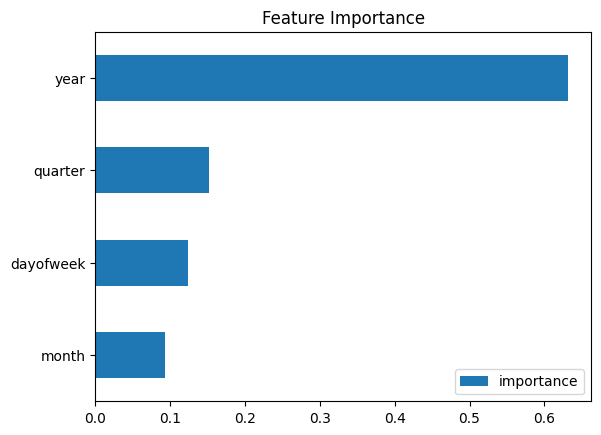

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [36]:
score = mean_squared_error(y_test, reg.predict(X_test))
print(f'MSE Score on Test set: {score:0.2f}')

MSE Score on Test set: 0.07
